In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split


dataset = fetch_california_housing()

data = pd.DataFrame(dataset.data, columns=dataset.feature_names)
data['target'] = dataset.target

print(len(data))
data.head(10)

20640


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611


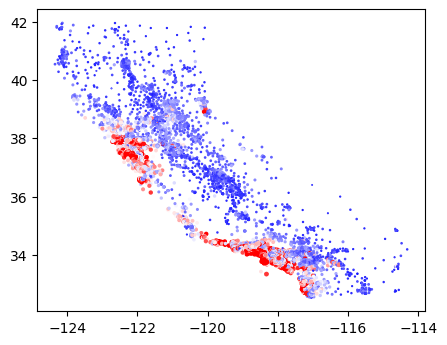

In [2]:
plt.figure(figsize=(5, 4), dpi=100)
plt.scatter(data.Longitude, data.Latitude, s=data.target, c=data.target, cmap='bwr');

A kNN model might be quite reasonable to use on this 2D subspace.




In [3]:
# Let's first divide our data into train and test:

X, y = data.drop('target', axis=1), data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(15480, 8) (5160, 8) (15480,) (5160,)


In [4]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

### 1. Build a kNN regressor on the Longitude and Latitude features

In [5]:
X_1 = data[['Latitude', 'Longitude']]
X_1_train = X_train[['Latitude', 'Longitude']]
X_1_test = X_test[['Latitude', 'Longitude']]

KNR = KNeighborsRegressor(n_neighbors=10)
KNR.fit(X_1_train, y_train)

pred1 = KNR.predict(X_1_test)

print(pred1)
print(dataset.target)

[4.918808 2.145    3.097    ... 2.0927   1.5641   0.7425  ]
[4.526 3.585 3.521 ... 0.923 0.847 0.894]


### 2. Build a random forest regressor on the rest of the features

In [6]:
X_2 = X.drop(['Latitude', 'Longitude'], axis=1)
X_2_train = X_train.drop(['Latitude', 'Longitude'], axis=1)
X_2_test = X_test.drop(['Latitude', 'Longitude'], axis=1)

RFR = RandomForestRegressor(n_estimators=10)
RFR.fit(X_2_train, y_train)

pred2 = RFR.predict(X_2_test)

print(pred2)
print(dataset.target)

[3.831301 3.4182   4.317505 ... 2.7984   1.1302   1.4328  ]
[4.526 3.585 3.521 ... 0.923 0.847 0.894]


### 3. Build a stacking regressor with: 
    - 5-fold cross-val-predict 
    - the two models above as the base models 
    - a linear regression model as the final (aggregating) estimator

In [7]:
# define the base models
level0 = list()
level0.append(('KNR', KNR))
level0.append(('RFR', RFR))

# define meta learner model
level1 = LinearRegression()

# define the stacking ensemble
SR = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)

# fit the model on the test data
SR.fit(X_train, y_train)

# make a prediction
pred3 = SR.predict(X_test)
print(pred3)
print(dataset.target)

[4.16544591 2.57602295 4.42329721 ... 2.71558296 1.67505377 0.78144096]
[4.526 3.585 3.521 ... 0.923 0.847 0.894]


### Compare the test MSE losses of the 3 models above

[0.3090878479732854, 0.47082548496716303, 0.29881704851099633]


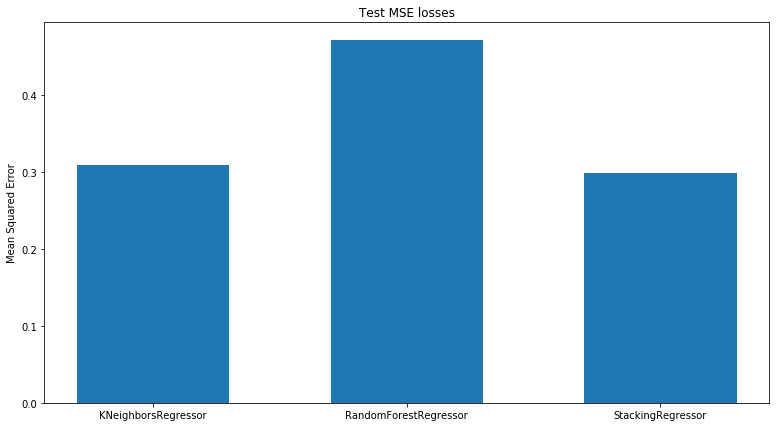

In [24]:
# plot models' performance for comparison

names = ['KNeighborsRegressor', 'RandomForestRegressor', 'StackingRegressor']

MSE_KNR = mean_squared_error(y_test, KNR.predict(X_1_test))
MSE_RFR = mean_squared_error(y_test, RFR.predict(X_2_test))
MSE_SR = mean_squared_error(y_test, SR.predict(X_test))

MSE_results = [MSE_KNR, MSE_RFR, MSE_SR]
print(MSE_results)

plt.figure(figsize=(13, 7))
plt.bar(names, MSE_results, width=0.6)
plt.title('Test MSE losses')
plt.ylabel('Mean Squared Error')

plt.show()